In [1]:
import json
import ast
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import time


# Loading the  robustness results

In [2]:
all_file_folder = {}
for folder in os.listdir('../../benchmark/'):
    if "." not in folder:
        all_files = [] 
        for file in os.listdir('../../benchmark/{}/'.format(folder)):
            all_files.append('{}_robustness.txt'.format(file))
        all_file_folder[folder] = all_files

In [3]:



def generate_dict(list_file):
    all_dict_lag = []
    for file_s in os.listdir(dirname_lag):
        if file_s in list_file:
            f  = ast.literal_eval(open(dirname_lag+file_s).read()[:-1])
            all_dict_lag.append(f)

    all_dict_noise = []
    for file_s in os.listdir(dirname_noise):
        if file_s in list_file:
            f  = ast.literal_eval(open(dirname_noise+file_s).read()[:-1])
            all_dict_noise.append(f)

    all_dict_percentage = []
    for file_s in os.listdir(dirname_percentage):
        if file_s in list_file:
            f  = ast.literal_eval(open(dirname_percentage+file_s).read()[:-1])
            all_dict_percentage.append(f)
    return all_dict_lag,all_dict_noise,all_dict_percentage
    

def group_dict(all_dict_lag):
    d_lag = {}
    for k in list(all_dict_lag[0].keys())[::-1]:
        d_lag[k] = tuple(d[k] for d in all_dict_lag)
    return d_lag


dirname_lag =  '../../results/robustness_results/result_data_aggregated_lag/'
dirname_noise =  '../../results/robustness_results/result_data_aggregated_noise/'
dirname_percentage =  '../../results/robustness_results/result_data_aggregated_percentage/'

all_dict = {}
for list_file_key in all_file_folder.keys():
    all_dict_lag,all_dict_noise,all_dict_percentage = generate_dict(all_file_folder[list_file_key])
    if len(all_dict_lag) > 1:
        all_dict[list_file_key] = {}
        all_dict[list_file_key]['lag'] = group_dict(all_dict_lag)
        all_dict[list_file_key]['noise'] = group_dict(all_dict_noise)
        all_dict[list_file_key]['percentage'] = group_dict(all_dict_percentage)

In [4]:
overall_dict,all_dict_mean_norm,all_dict_mean = {},{},{}
all_dict_mean['lag'],all_dict_mean['noise'],all_dict_mean['percentage'] = {},{},{}
all_dict_mean_norm['lag'],all_dict_mean_norm['noise'],all_dict_mean_norm['percentage'] = {},{},{}
for key_metric in list(all_dict['ECG']['percentage'].keys()):
    for key_exp in all_dict_mean.keys():
        overall_dict[key_metric] = []
        all_dict_mean[key_exp][key_metric] = []
        all_dict_mean_norm[key_exp][key_metric] = []

for list_file_key in all_file_folder.keys():
    all_dict_lag,all_dict_noise,all_dict_percentage = generate_dict(all_file_folder[list_file_key])
    if len(all_dict_lag) > 1:
        for key_metric in list(all_dict['ECG']['percentage'].keys()):
            all_dict_mean['lag'][key_metric] += [val for val in group_dict(all_dict_lag)[key_metric]]
            all_dict_mean['noise'][key_metric] += [val for val in group_dict(all_dict_noise)[key_metric]]
            all_dict_mean['percentage'][key_metric] += [val for val in group_dict(all_dict_percentage)[key_metric]]
            all_dict_mean_norm['lag'][key_metric] += [np.mean(group_dict(all_dict_lag)[key_metric])]
            all_dict_mean_norm['noise'][key_metric] += [np.mean(group_dict(all_dict_noise)[key_metric])]
            all_dict_mean_norm['percentage'][key_metric] += [np.mean(group_dict(all_dict_percentage)[key_metric])]
                

for key_metric in list(all_dict['ECG']['percentage'].keys()):
    overall_dict[key_metric] = [np.mean([
        np.mean(all_dict_mean_norm['lag'][key_metric]),
        np.mean(all_dict_mean_norm['noise'][key_metric]),
        ])]

# Plotting the overall robustness results for each dataset in the benchmark

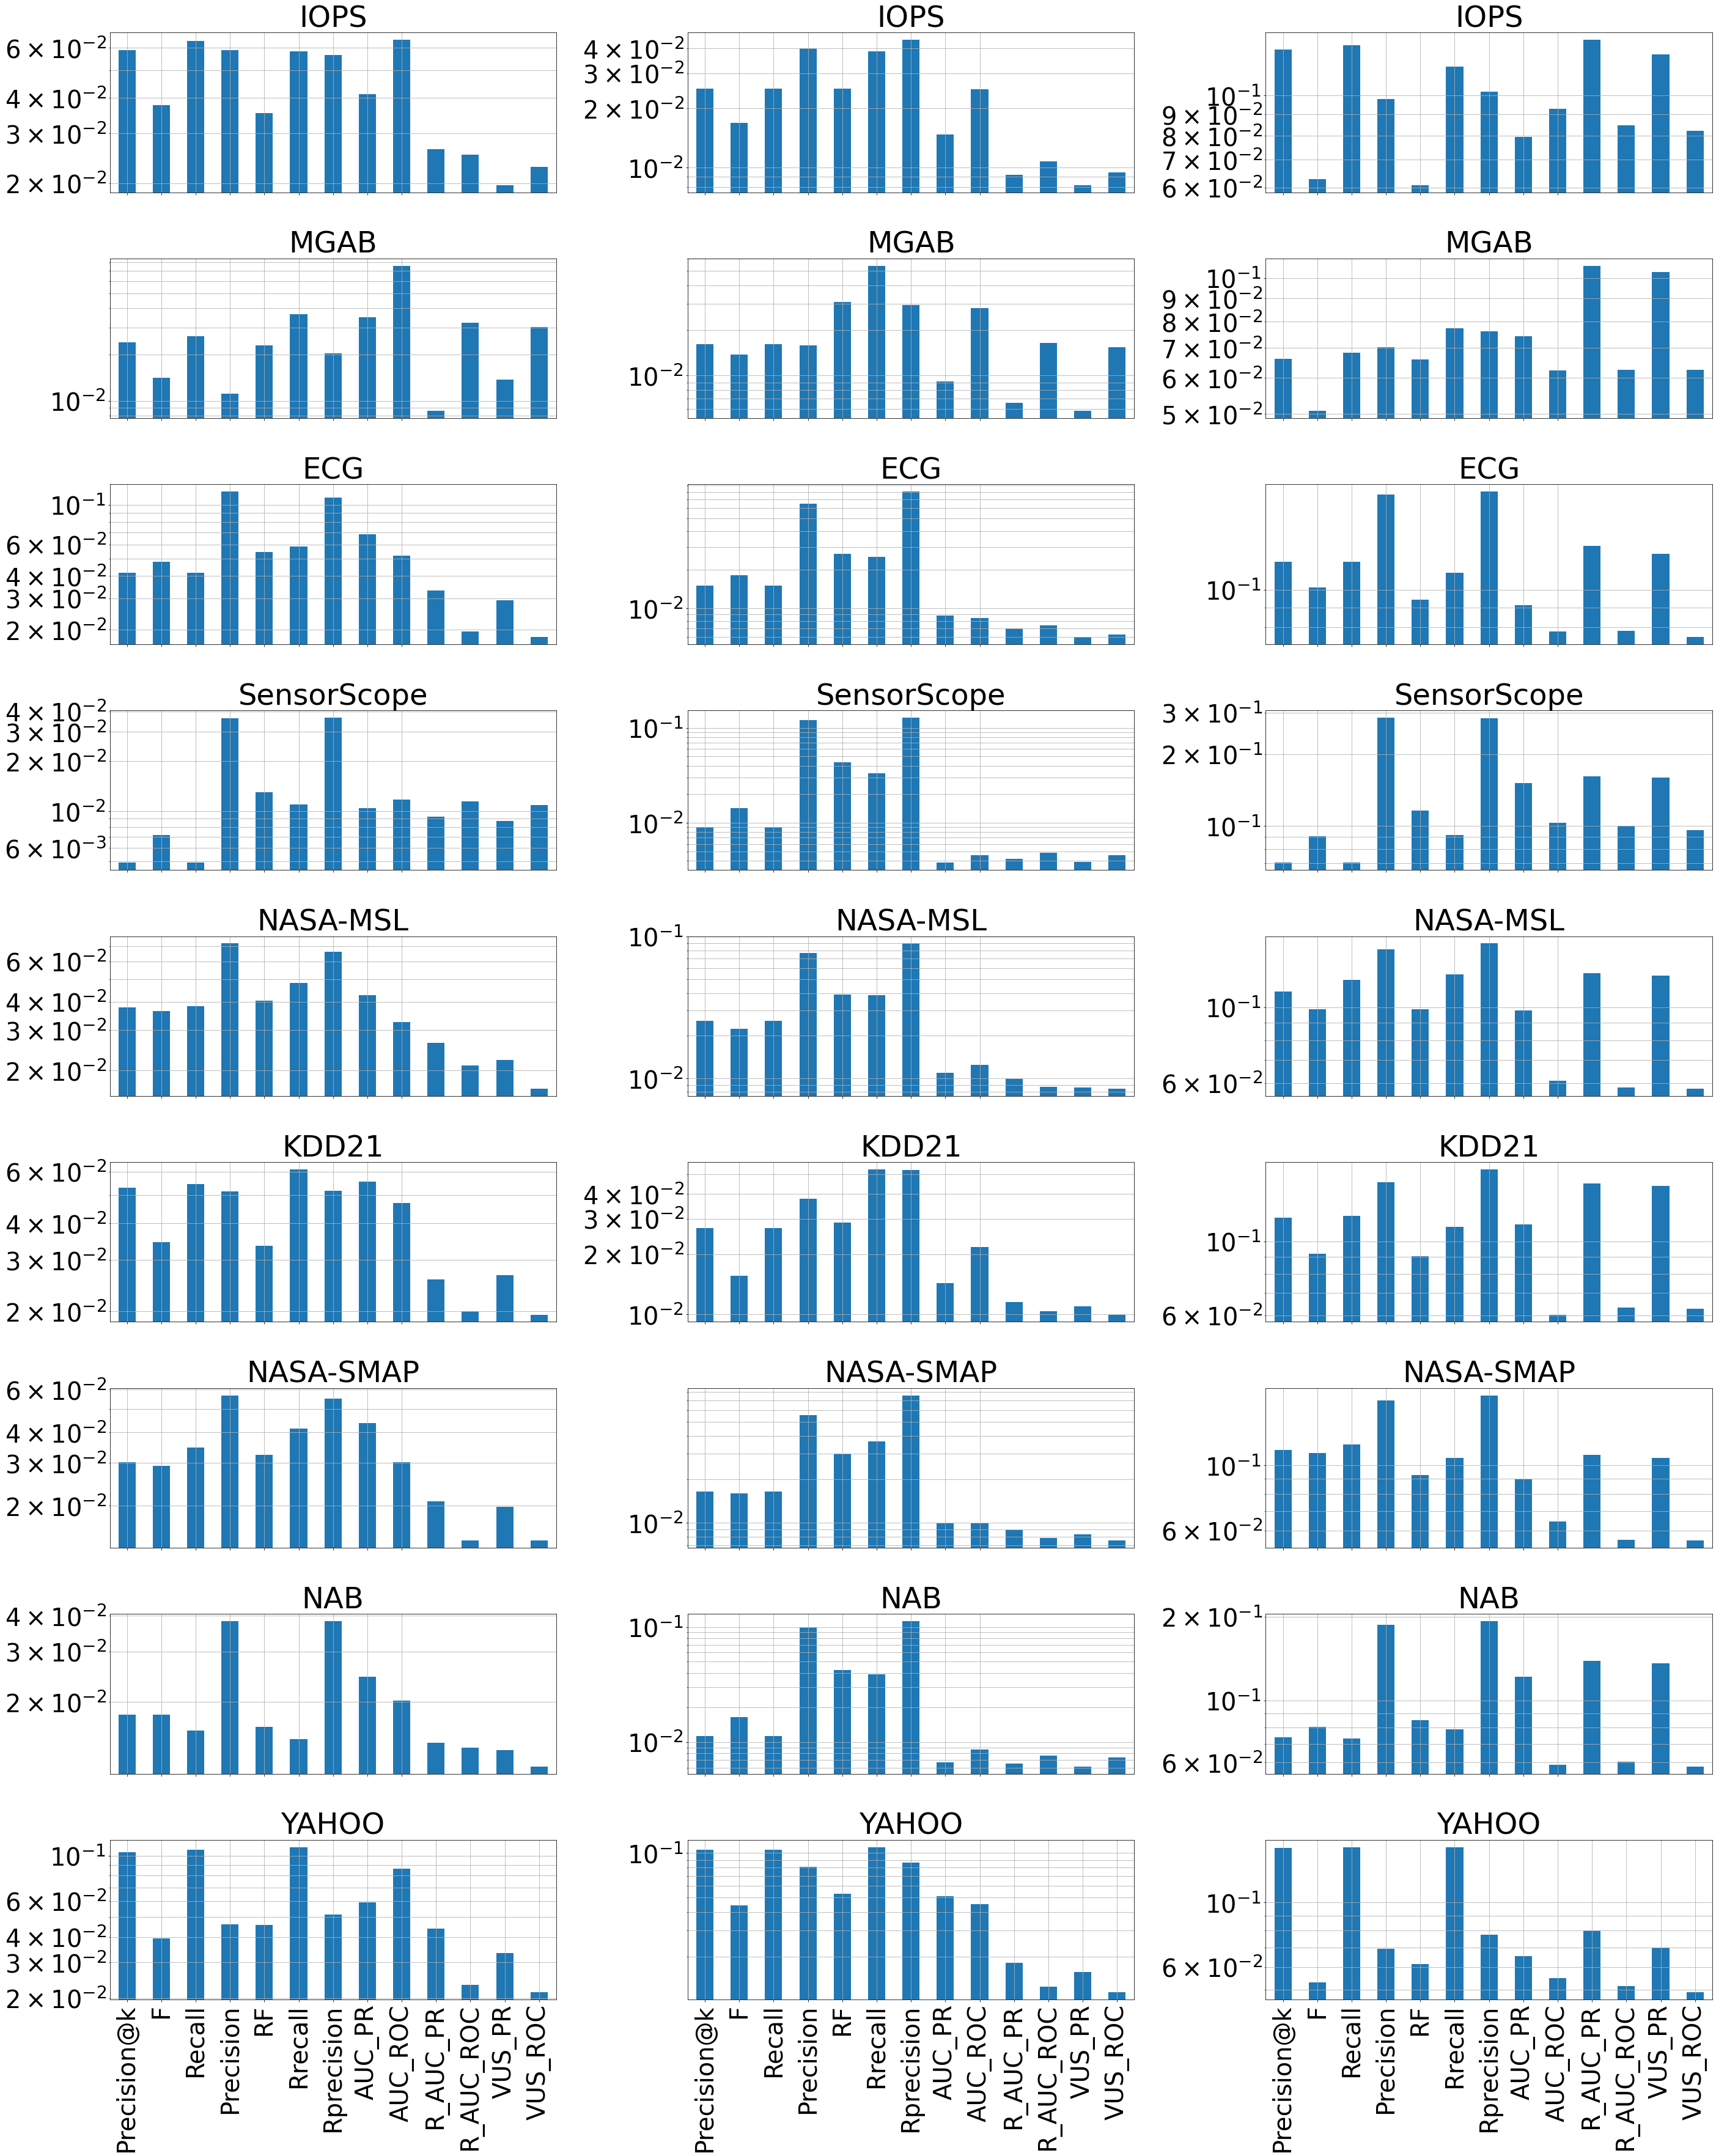

In [23]:
plt.figure(figsize=(40,50))
for i,key in enumerate(['IOPS', 'MGAB', 'ECG', 'SensorScope', 'NASA-MSL', 'KDD21', 'NASA-SMAP', 'NAB', 'YAHOO']):#['IOPS', 'NASA-MSL', 'KDD21', 'NASA-SMAP', 'YAHOO','ECG']):
    plt.subplot(len(all_dict.keys()),3,1+i*3)
    plt.yscale('log')
    plt.title('{}'.format(key))
    pd.DataFrame.from_dict(all_dict[key]['lag']).mean().plot.bar()
    plt.grid(which="both")
    if i == len(all_dict.keys())-1: plt.xticks(rotation=90)
    else: plt.xticks([val for val in range(len(all_dict.keys()))],['' for val in range(len(all_dict.keys()))])
    plt.subplot(len(all_dict.keys()),3,2+i*3)
    plt.yscale('log')
    plt.title('{}'.format(key))
    pd.DataFrame.from_dict(all_dict[key]['noise']).mean().plot.bar()
    if i == len(all_dict.keys())-1: plt.xticks(rotation=90)
    else: plt.xticks([val for val in range(len(all_dict.keys()))],['' for val in range(len(all_dict.keys()))])
    plt.grid(which="both")
    plt.subplot(len(all_dict.keys()),3,3+i*3)
    plt.yscale('log')
    plt.title('{}'.format(key))
    pd.DataFrame.from_dict(all_dict[key]['percentage']).mean().plot.bar()
    if i == len(all_dict.keys())-1: plt.xticks(rotation=90)
    else: plt.xticks([val for val in range(len(all_dict.keys()))],['' for val in range(len(all_dict.keys()))])
    plt.grid(which="both")
    

plt.tight_layout()
plt.savefig('results_figures/per_average.pdf',format='pdf')

# Plotting the overall robustness results across all datasets

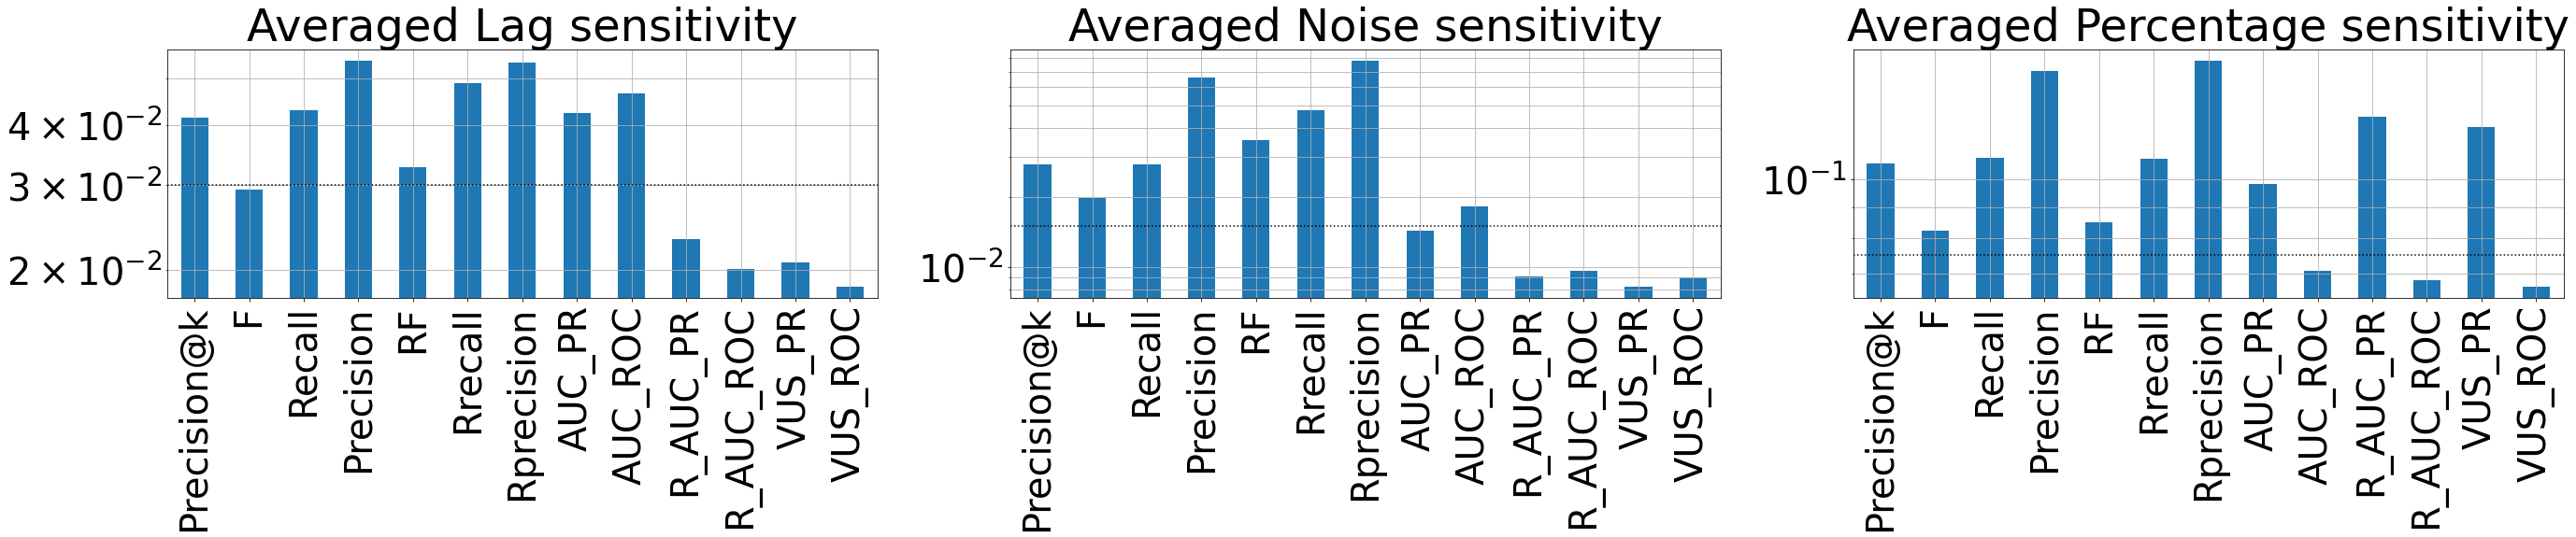

In [24]:
plt.rcParams.update({'font.size': 40})
#res_dataframe.mean().plot.bar()
plt.figure(figsize=(40,9))
plt.subplot(1,3,1)
plt.title('Averaged Lag sensitivity')
pd.DataFrame.from_dict(all_dict_mean_norm['lag']).mean().plot.bar()
plt.yscale('log')
plt.xticks(rotation=90)
plt.grid(which="both")
plt.axhline(0.03,c='black',linestyle='dotted')

plt.subplot(1,3,2)
plt.title('Averaged Noise sensitivity')
pd.DataFrame.from_dict(all_dict_mean_norm['noise']).mean().plot.bar()
plt.yscale('log')
plt.xticks(rotation=90)
plt.grid(which="both")
plt.axhline(0.015,c='black',linestyle='dotted')

plt.subplot(1,3,3)
plt.title('Averaged Percentage sensitivity')
pd.DataFrame.from_dict(all_dict_mean_norm['percentage']).mean().plot.bar()
plt.yscale('log')
plt.xticks(rotation=90)
plt.grid(which="both")
plt.axhline(0.075,c='black',linestyle='dotted')
plt.tight_layout()
plt.savefig('results_figures/global_average.pdf')

In [62]:
global_dataframe = pd.DataFrame(columns=['folder','file_name','measure','type','value'])

for folder in all_dict.keys():
    for measure in ['Precision','Rprecision','Recall','Rrecall','Precision@k','F','RF','AUC_PR','AUC_ROC']:
        if measure not in ['R_AUC_ROC','R_AUC_PR','VUS_ROC','VUS_PR']:
            for i,(lag,noise,ratio) in enumerate(zip(all_dict[folder]['lag'][measure],all_dict[folder]['noise'][measure],all_dict[folder]['percentage'][measure])):
                    to_append_lag = {'folder': folder,
                                 'file_name': "{}_{}".format(folder,i),
                                 'measure': measure,
                                 'type': 'lag',
                                 'value': lag}
                    to_append_noise = {'folder': folder,
                                 'file_name': "{}_{}".format(folder,i),
                                 'measure': measure,
                                 'type': 'noise',
                                 'value': noise}
                    to_append_ratio = {'folder': folder,
                                 'file_name': "{}_{}".format(folder,i),
                                 'measure': measure,
                                 'type': 'ratio',
                                 'value': ratio}
                    global_dataframe = global_dataframe.append(to_append_lag, ignore_index=True)
                    global_dataframe = global_dataframe.append(to_append_noise, ignore_index=True)
                    global_dataframe = global_dataframe.append(to_append_ratio, ignore_index=True)



<ipython-input-116-31f6160323e4>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes()


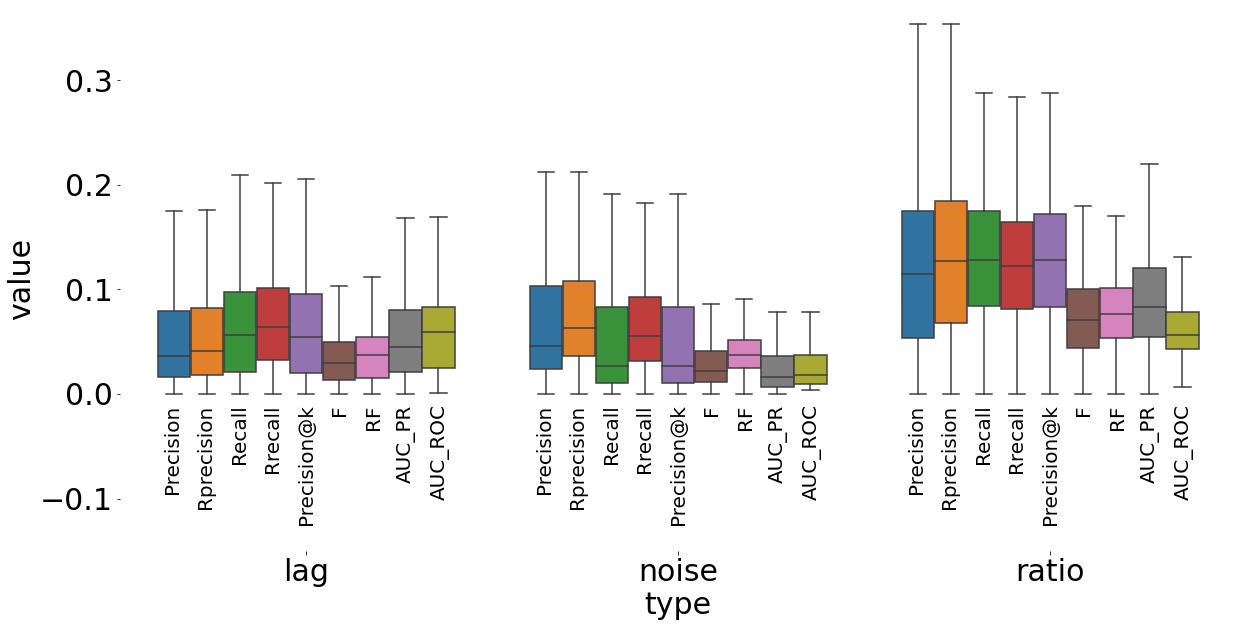

In [116]:
import seaborn as sns
plt.rcParams.update({'font.size': 30})
step = 0.36/4
measures_name = ['Precision','Rprecision','Recall','Rrecall','Precision@k','F','RF','AUC_PR','AUC_ROC']

plt.figure(figsize=(20,10))
sns.boxplot(x="type", y="value", hue="measure",
              data=global_dataframe,showfliers=False)
#plt.axhline(-0.005,color='black')
plt.legend().set_visible(False)
plt.box(False)
plt.ylim(-0.15,0.37)
for init_pos in [0,1,2]:
    for pos,name in zip([-4,-3,-2,-1,0,1,2,3,4],measures_name):
        plt.text(init_pos+pos*step-0.025,-0.01,name,fontdict={'size': 20},rotation=90,verticalalignment='top')